In [1]:
# HWES example
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
#from sklearn.utils import shuffle
#from sklearn.model_selection import KFold

                  temperature  humidite  IQ  IQ_J+1  IQ_J+2  IQ_J+3
Date                                                               
29/11/2019 12:00          8.5      73.0   3       4       6       5
29/11/2019 09:00          6.3      90.0   3       4       6       5
29/11/2019 06:00          6.7      95.0   3       4       6       5
29/11/2019 03:00          7.5      91.0   3       4       6       5
29/11/2019 00:00          8.3      97.0   3       4       6       5


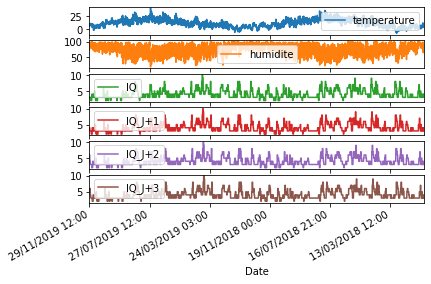

In [159]:
#dataset
CSV_PATH = "Datasets/"
CSV_NAME = "trainingDatasetDplus3.csv"
features_considered = ['temperature','humidite','IQ','IQ_J+1','IQ_J+2','IQ_J+3']

df = pd.read_csv(CSV_PATH+CSV_NAME, header=0, index_col='Date', delimiter=';')

features = df[features_considered]
#features.index = df['Date']

print(features.head())
features.plot(subplots=True)
plt.show()

dataset = features.values

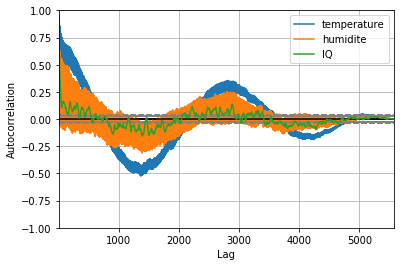

In [160]:
pd.plotting.autocorrelation_plot(features.temperature, label ='temperature')
pd.plotting.autocorrelation_plot(features.humidite, label = 'humidite')
pd.plotting.autocorrelation_plot(features.IQ, label = 'IQ')

In [161]:
def adfuller_test(series,signif=0.05,name='',verbose=False):
    """Perform ADFuller to test for Stationarity of giver series and print report"""
    r = adfuller(series,autolag='AIC')
    output = {'test_statistic':round(r[0],4), 'pvalue':round(r[1],4), 'n_lags':round(r[2],4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val,length= 6):return str(val).ljust(length)
    
    #Print summary
    print(f'Augmented Dickey-Fuller Test on "{name}"', "\n   ", "-"*47)
    print(f'Null Hypothesis: Data has unit root. Non-Stationarity.')
    print(f'Significative Level = {signif}')
    print(f'Test Statistic = {output["test_statistic"]}')
    print(f'No. Lags Chosen = {output["n_lags"]}')
    
    for key,val in r[4].items():
          print(f' Critical value {adjust(key)} = {round(val,3)}')
        
    if p_value <= signif:
          print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
          print(f" => Series is Stationary.")
    else :
          print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
          print(f" => Series is Non-Stationary.")
#ADF Test on each column 
for name,column in features.iteritems():
    adfuller_test(column, name = column.name)
    print('\n')

Augmented Dickey-Fuller Test on "temperature" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationarity.
Significative Level = 0.05
Test Statistic = -3.6738
No. Lags Chosen = 33
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0045. Rejecting Null Hypothesis.
 => Series is Stationary.


Augmented Dickey-Fuller Test on "humidite" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationarity.
Significative Level = 0.05
Test Statistic = -6.8532
No. Lags Chosen = 32
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


Augmented Dickey-Fuller Test on "IQ" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationarity.
Significative Level = 0.05
Test Statistic = -8.1653
No. Lags 

In [162]:
train = dataset[:int(0.8*len(features))]
x_test = dataset[int(0.8*len(features)):,0:3] 

#For the comparison after 
x_train = dataset[:int(0.8*len(features)),0:3]
y_train = dataset[:int(0.8*len(features)),3:]
y_test = dataset[int(0.8*len(features)):,3:]


print(dataset.shape)
print(train.shape)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(5568, 6)
(4454, 6)
(4454, 3)
(4454, 3)
(1114, 3)


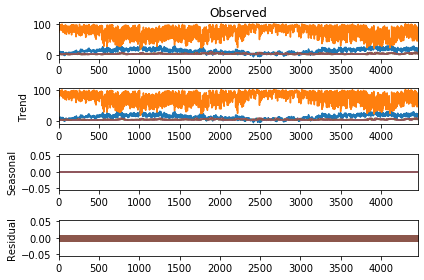

In [163]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train, model='additive', period=1)
result.plot()
pyplot.show()

In [173]:
#fit model
span = 1 # The model will consider the last months weighted average for forecasting
alpha = 2/(span+1)
print(train.reshape(-1,1).shape)
model = ExponentialSmoothing(train.reshape(-1),trend='add',seasonal_periods=1)
model_fit = model.fit(smoothing_level=alpha)
model_fit.summary()

(26724, 1)


Dep. Variable:,endog,No. Observations:,26724
Model:,ExponentialSmoothing,SSE,43928642.898
Optimized:,True,AIC,197892.801
Trend:,Additive,BIC,197925.574
Seasonal:,None,AICC,197892.804
Seasonal Periods:,None,Date:,"Thu, 26 Mar 2020"
Box-Cox:,False,Time:,15:00:40
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,False
smoothing_slope,0.000000,beta,True


In [174]:
#make prediction
prediction = model_fit.forecast(8)
print(prediction)

[6.00029193 6.00058386 6.00087579 6.00116772 6.00145966 6.00175159
 6.00204352 6.00233545]


In [175]:
def calc_accuracy(y_pred,y_true):
    """
    calculate the accurracy of the prediction according to the true value
    """
    count=0
    for i in range(0,len(y_true)):
        if y_true[i]==round(y_pred[i][0]):
            count+=1
    if count==0:
        return(0)
    return((count/len(y_true))*100)

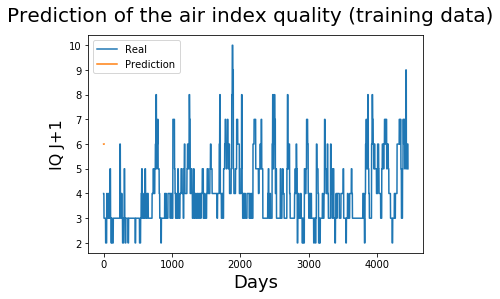

In [176]:
plt.plot(y_train[:,0], label='Real')
plt.plot(prediction[:,], label='Prediction')
plt.suptitle('Prediction of the air index quality (training data)', fontsize=20)
plt.xlabel('Days', fontsize=18)
plt.ylabel('IQ J+1', fontsize=16)
plt.legend()
plt.show()

#print("Accuracy with training data:", round(calc_accuracy(prediction,y_train),0) ,"%")
#print("Mean error with training data:", round(mean_error(y_pred_train,y_train),2))